# 데이터셋 준비

In [1]:
import pandas as pd
gt_raw=pd.read_csv("filtered_gene_expression_10.csv",index_col=0)

In [2]:
adj_matrix=pd.read_csv("adj_matrix.csv",index_col=0)

In [3]:
import numpy as np
samples = gt_raw.index

def get_label(s):
    if s.startswith("GTEX"):
        return 0 #normal
    if s.startswith("TCGA"):
        code = s.split("-")[3][:2]
        if code == "01":
            return 1 #normal
        elif code == "11":
            return 0 #normal
    return np.NaN #other

labels = [get_label(s) for s in samples]

label_df = pd.DataFrame({"sample": samples, "label": labels}).set_index(keys='sample')

In [4]:
expr_withlabel=pd.concat([gt_raw[list(set(adj_matrix.columns)&set(gt_raw.columns))],label_df],axis=1)

In [5]:
adj=adj_matrix[list(set(adj_matrix.columns)&set(gt_raw.columns))].T[list(set(adj_matrix.columns)&set(gt_raw.columns))]

# 모델 학습

## GCN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch.utils.data import random_split
import numpy as np
import pandas as pd
from sklearn.utils import resample
import time


torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# ================================
# Dataset 준비
# ================================
expr = expr_withlabel.drop(columns=['label'])
labels = expr_withlabel['label'].values

normal_idx = np.where(labels == 0)[0]
tumor_idx = np.where(labels == 1)[0]

down_tumor_idx = resample(tumor_idx, replace=False, n_samples=len(normal_idx), random_state=42)

balanced_idx = np.concatenate([normal_idx, down_tumor_idx])
np.random.shuffle(balanced_idx)

expr_balanced = expr.iloc[balanced_idx].values
labels_balanced = labels[balanced_idx]


# ================================
# GCNConv에 사용할 edge_index
# ================================
row_idx, col_idx = np.where(adj.values == 1)
edge_index = torch.tensor(np.vstack((row_idx, col_idx)), dtype=torch.long)


# PyG Data 객체 생성
data_list = []
for i in range(len(expr_balanced)):
    x = torch.tensor(expr_balanced[i], dtype=torch.float32).unsqueeze(1)
    y = torch.tensor([labels_balanced[i]], dtype=torch.long)
    data_list.append(Data(x=x, edge_index=edge_index, y=y))


# Train/Test split
train_size = int(0.7 * len(data_list))
test_size = len(data_list) - train_size
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# ================================
# 개선된 GCN 모델
# ================================
class GeneGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.2):
        super(GeneGCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        self.dropout = dropout
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x)

        graph_emb = global_mean_pool(x, batch)
        out = self.fc(graph_emb)
        return out


model = GeneGCN(num_features=1, hidden_dim=32, num_classes=2, dropout=0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()


# ================================
# Training + 개선된 epoch 기록
# ================================
epoch_losses = []
epoch_times = []

for epoch in range(50):
    model.train()
    t0 = time.time()

    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    epoch_times.append(time.time() - t0)

    print(f"Epoch {epoch+1:03d}, Avg Loss: {avg_loss:.4f}")


# ================================
# Evaluation
# ================================
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
        correct += (pred == batch.y.view(-1)).sum().item()
        total += batch.num_graphs

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


# 로그 저장
pd.DataFrame({
    "Epoch": np.arange(1, len(epoch_losses)+1),
    "Avg_Train_Loss": epoch_losses,
    "Epoch_Time_sec": epoch_times
}).to_csv("epoch_log_gcn.csv", index=False)


Using device: cuda


/tmp/ipykernel_2203059/3181764471.py:56: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
/tmp/ipykernel_2203059/3181764471.py:57: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 001, Avg Loss: 0.6928
Epoch 002, Avg Loss: 0.6876
Epoch 003, Avg Loss: 0.6811
Epoch 004, Avg Loss: 0.6747
Epoch 005, Avg Loss: 0.6711
Epoch 006, Avg Loss: 0.6663
Epoch 007, Avg Loss: 0.6615
Epoch 008, Avg Loss: 0.6571
Epoch 009, Avg Loss: 0.6551
Epoch 010, Avg Loss: 0.6510
Epoch 011, Avg Loss: 0.6491
Epoch 012, Avg Loss: 0.6479
Epoch 013, Avg Loss: 0.6462
Epoch 014, Avg Loss: 0.6438
Epoch 015, Avg Loss: 0.6428
Epoch 016, Avg Loss: 0.6440
Epoch 017, Avg Loss: 0.6418
Epoch 018, Avg Loss: 0.6397
Epoch 019, Avg Loss: 0.6402
Epoch 020, Avg Loss: 0.6372
Epoch 021, Avg Loss: 0.6384
Epoch 022, Avg Loss: 0.6383
Epoch 023, Avg Loss: 0.6367
Epoch 024, Avg Loss: 0.6361
Epoch 025, Avg Loss: 0.6343
Epoch 026, Avg Loss: 0.6351
Epoch 027, Avg Loss: 0.6337
Epoch 028, Avg Loss: 0.6362
Epoch 029, Avg Loss: 0.6325
Epoch 030, Avg Loss: 0.6344
Epoch 031, Avg Loss: 0.6337
Epoch 032, Avg Loss: 0.6328
Epoch 033, Avg Loss: 0.6319
Epoch 034, Avg Loss: 0.6333
Epoch 035, Avg Loss: 0.6323
Epoch 036, Avg Loss:

In [29]:
model.eval()
correct = 0
total = 0
preds = []
prediction=[]
real=[]
labels_true = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        prediction.append(pred.cpu().numpy())
        labels_true.extend(batch.y.cpu().numpy())
        real.append(batch.y.cpu().numpy())
        correct += (pred == batch.y).sum().item()
        total += batch.num_graphs

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6641


In [30]:
final_pred=[]
for i in prediction:
    for j in i:
        final_pred.append(j)

final_real=[]
for i in real:
    for j in i:
        final_real.append(j)

<Figure size 500x500 with 0 Axes>

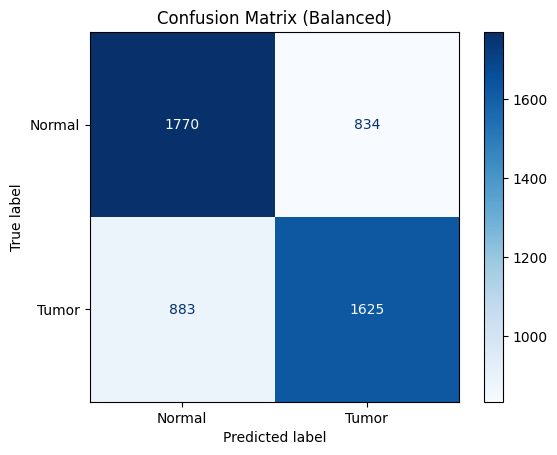

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# 7️⃣ Confusion Matrix 시각화
# =====================
cm = confusion_matrix(final_real, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Balanced)")
plt.show()


## GraphSAGE

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch.utils.data import random_split
import numpy as np
import pandas as pd
from sklearn.utils import resample
import time

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ---------------------------
# Dataset 준비
# ---------------------------
expr = expr_withlabel.drop(columns=['label'])
labels = expr_withlabel['label'].values

normal_idx = np.where(labels == 0)[0]
tumor_idx = np.where(labels == 1)[0]

down_tumor_idx = resample(tumor_idx, replace=False, n_samples=len(normal_idx), random_state=42)

balanced_idx = np.concatenate([normal_idx, down_tumor_idx])
np.random.shuffle(balanced_idx)

expr_balanced = expr.iloc[balanced_idx].values
labels_balanced = labels[balanced_idx]

print(f"Balanced dataset: Normal={len(normal_idx)}, Tumor={len(down_tumor_idx)}")

# edge_index 생성
row_idx, col_idx = np.where(adj.values == 1)
edge_index = torch.tensor(np.vstack((row_idx, col_idx)), dtype=torch.long)

# PyG Data 객체 생성
data_list = []
for i in range(len(expr_balanced)):
    x = torch.tensor(expr_balanced[i], dtype=torch.float32).unsqueeze(1)  # [nodes, 1]
    y = torch.tensor([labels_balanced[i]], dtype=torch.long)
    data_list.append(Data(x=x, edge_index=edge_index, y=y))

# Train / Test split (validation 제거)
train_size = int(0.7 * len(data_list))
test_size = len(data_list) - train_size
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ---------------------------
# Model 정의
# ---------------------------
class GeneGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_classes, dropout=0.25):
        super(GeneGraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)

        self.fc = nn.Linear(hidden_dim, num_classes)
        self.act = nn.ReLU()
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.sage1(x, edge_index)
        x = self.norm1(x)
        x = self.act(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.sage2(x, edge_index)
        x = self.norm2(x)
        x = self.act(x)

        x = global_mean_pool(x, batch)  # graph-level pooling
        return self.fc(x)

model = GeneGraphSAGE(in_channels=1, hidden_dim=64, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# ---------------------------
# Training (No validation)
# ---------------------------
max_epochs = 50
epoch_losses = []
epoch_times = []

for epoch in range(1, max_epochs + 1):
    model.train()
    t0 = time.time()
    total_loss = 0.0
    n_batches = 0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / n_batches
    epoch_losses.append(avg_loss)
    epoch_times.append(time.time() - t0)

    print(f"Epoch {epoch:03d} | Train Loss: {avg_loss:.4f}")

# ---------------------------
# Test
# ---------------------------
model.eval()
correct = 0
total = 0
preds = []
labels_true = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = torch.argmax(out, dim=1)

        preds.extend(pred.cpu().numpy())
        labels_true.extend(batch.y.view(-1).cpu().numpy())
        correct += (pred == batch.y.view(-1)).sum().item()
        total += batch.num_graphs

accuracy = correct / total
print(f"Final Test Accuracy: {accuracy:.4f}")

# ---------------------------
# Epoch 로그 저장
# ---------------------------
df_epoch_log = pd.DataFrame({
    "Epoch": np.arange(1, len(epoch_losses) + 1),
    "Avg_Train_Loss": epoch_losses,
    "Epoch_Time_sec": epoch_times
})
df_epoch_log.to_csv("epoch_log_graphSAGE.csv", index=False)

# 추가: Classification report
try:
    from sklearn.metrics import classification_report
    print(classification_report(labels_true, preds))
except:
    pass


Using device: cuda
Balanced dataset: Normal=8519, Tumor=8519


/tmp/ipykernel_2203059/886941825.py:53: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
/tmp/ipykernel_2203059/886941825.py:54: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Epoch 001 | Train Loss: 0.6491
Epoch 002 | Train Loss: 0.5777
Epoch 003 | Train Loss: 0.5519
Epoch 004 | Train Loss: 0.5380
Epoch 005 | Train Loss: 0.5236
Epoch 006 | Train Loss: 0.5099
Epoch 007 | Train Loss: 0.5149
Epoch 008 | Train Loss: 0.4998
Epoch 009 | Train Loss: 0.4983
Epoch 010 | Train Loss: 0.4975
Epoch 011 | Train Loss: 0.4962
Epoch 012 | Train Loss: 0.4900
Epoch 013 | Train Loss: 0.4909
Epoch 014 | Train Loss: 0.4830
Epoch 015 | Train Loss: 0.4829
Epoch 016 | Train Loss: 0.4801
Epoch 017 | Train Loss: 0.4774
Epoch 018 | Train Loss: 0.4686
Epoch 019 | Train Loss: 0.4781
Epoch 020 | Train Loss: 0.4785
Epoch 021 | Train Loss: 0.4701
Epoch 022 | Train Loss: 0.4688
Epoch 023 | Train Loss: 0.4678
Epoch 024 | Train Loss: 0.4681
Epoch 025 | Train Loss: 0.4657
Epoch 026 | Train Loss: 0.4661
Epoch 027 | Train Loss: 0.4656
Epoch 028 | Train Loss: 0.4618
Epoch 029 | Train Loss: 0.4600
Epoch 030 | Train Loss: 0.4573
Epoch 031 | Train Loss: 0.4569
Epoch 032 | Train Loss: 0.4569
Epoch 03

In [51]:
model.eval()
correct = 0
total = 0
preds = []
prediction=[]
real=[]
labels_true = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        prediction.append(pred.cpu().numpy())
        labels_true.extend(batch.y.cpu().numpy())
        real.append(batch.y.cpu().numpy())
        correct += (pred == batch.y).sum().item()
        total += batch.num_graphs

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6197


In [52]:
final_pred=[]
for i in prediction:
    for j in i:
        final_pred.append(j)

final_real=[]
for i in real:
    for j in i:
        final_real.append(j)

<Figure size 500x500 with 0 Axes>

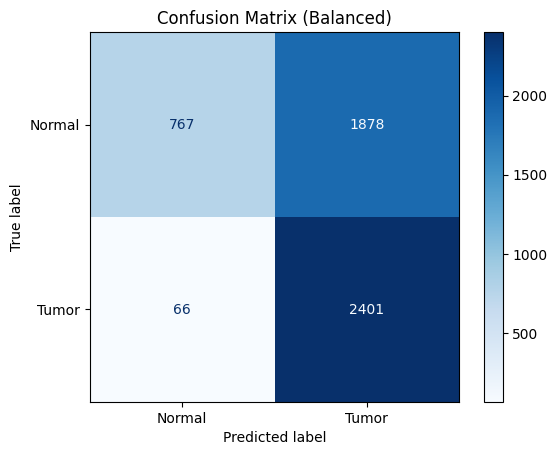

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# 7️⃣ Confusion Matrix 시각화
# =====================
cm = confusion_matrix(final_real, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Balanced)")
plt.show()


# GAT

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch.utils.data import random_split
import numpy as np
import pandas as pd
from sklearn.utils import resample
import time


torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ================================
# Dataset 준비
# ================================
expr = expr_withlabel.drop(columns=['label'])
labels = expr_withlabel['label'].values

normal_idx = np.where(labels == 0)[0]
tumor_idx = np.where(labels == 1)[0]

down_tumor_idx = resample(tumor_idx, replace=False, n_samples=len(normal_idx), random_state=42)

balanced_idx = np.concatenate([normal_idx, down_tumor_idx])
np.random.shuffle(balanced_idx)

expr_balanced = expr.iloc[balanced_idx].values
labels_balanced = labels[balanced_idx]


# Edge index 준비
row_idx, col_idx = np.where(adj.values == 1)
edge_index = torch.tensor(np.vstack((row_idx, col_idx)), dtype=torch.long)


data_list = []
for i in range(len(expr_balanced)):
    x = torch.tensor(expr_balanced[i], dtype=torch.float32).unsqueeze(1)
    y = torch.tensor([labels_balanced[i]], dtype=torch.long)
    data_list.append(Data(x=x, edge_index=edge_index, y=y))


train_size = int(0.7 * len(data_list))
test_size = len(data_list) - train_size
train_dataset, test_dataset = random_split(data_list, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# ================================
#   GAT Architecture 개선 버전
# ================================
class GeneGAT(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_classes, heads=4, dropout=0.2):
        super(GeneGAT, self).__init__()
        
        self.gat1 = GATConv(in_channels, hidden_dim, heads=heads, concat=True, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False, dropout=dropout)

        # BatchNorm 대신 LayerNorm (node-level 입력에도 안정적)
        self.norm1 = nn.LayerNorm(hidden_dim * heads)
        self.norm2 = nn.LayerNorm(hidden_dim)

        self.dropout = dropout
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.act = nn.ELU()

    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)
        x = self.norm1(x)
        x = self.act(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.gat2(x, edge_index)
        x = self.norm2(x)
        x = self.act(x)

        graph_emb = global_mean_pool(x, batch)
        out = self.fc(graph_emb)
        return out


model = GeneGAT(in_channels=1, hidden_dim=32, num_classes=2, heads=4, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


# ================================
#   Training 루프 + Early Stopping
# ================================
epoch_losses = []
epoch_times = []

best_loss = float('inf')
patience = 8
wait = 0

for epoch in range(80):
    t0 = time.time()

    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.view(-1))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    epoch_times.append(time.time() - t0)

    print(f"[Epoch {epoch+1:03d}] Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
        torch.save(model.state_dict(), "best_gat.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break


# ================================
#   Evaluation
# ================================
model.load_state_dict(torch.load("best_gat.pt"))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.batch).argmax(1)
        correct += (pred == batch.y.view(-1)).sum().item()
        total += batch.num_graphs

accuracy = correct / total
print(f"Final Test Accuracy: {accuracy:.4f}")


# 로그 저장
pd.DataFrame({
    "Epoch": np.arange(1, len(epoch_losses) + 1),
    "Avg_Train_Loss": epoch_losses,
    "Epoch_Time_sec": epoch_times
}).to_csv("epoch_log_GAT.csv", index=False)


/tmp/ipykernel_2203059/4203480832.py:52: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
/tmp/ipykernel_2203059/4203480832.py:53: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


[Epoch 001] Loss: 0.6412
[Epoch 002] Loss: 0.6023
[Epoch 003] Loss: 0.5854
[Epoch 004] Loss: 0.5803
[Epoch 005] Loss: 0.5621
[Epoch 006] Loss: 0.5554
[Epoch 007] Loss: 0.5411
[Epoch 008] Loss: 0.5446
[Epoch 009] Loss: 0.5304
[Epoch 010] Loss: 0.5326
[Epoch 011] Loss: 0.5280
[Epoch 012] Loss: 0.5251
[Epoch 013] Loss: 0.5162
[Epoch 014] Loss: 0.5166
[Epoch 015] Loss: 0.5146
[Epoch 016] Loss: 0.5191
[Epoch 017] Loss: 0.5138
[Epoch 018] Loss: 0.5028
[Epoch 019] Loss: 0.5000
[Epoch 020] Loss: 0.4951
[Epoch 021] Loss: 0.4978
[Epoch 022] Loss: 0.4941
[Epoch 023] Loss: 0.4893
[Epoch 024] Loss: 0.4896
[Epoch 025] Loss: 0.4928
[Epoch 026] Loss: 0.4814
[Epoch 027] Loss: 0.4792
[Epoch 028] Loss: 0.4879
[Epoch 029] Loss: 0.4766
[Epoch 030] Loss: 0.4784
[Epoch 031] Loss: 0.4713
[Epoch 032] Loss: 0.4762
[Epoch 033] Loss: 0.4698
[Epoch 034] Loss: 0.4648
[Epoch 035] Loss: 0.4680
[Epoch 036] Loss: 0.4610
[Epoch 037] Loss: 0.4610
[Epoch 038] Loss: 0.4661
[Epoch 039] Loss: 0.4618
[Epoch 040] Loss: 0.4658


In [25]:
model.eval()
correct = 0
total = 0
preds = []
prediction=[]
real=[]
labels_true = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        prediction.append(pred.cpu().numpy())
        labels_true.extend(batch.y.cpu().numpy())
        real.append(batch.y.cpu().numpy())
        correct += (pred == batch.y).sum().item()
        total += batch.num_graphs

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7936


In [26]:
final_pred=[]
for i in prediction:
    for j in i:
        final_pred.append(j)

final_real=[]
for i in real:
    for j in i:
        final_real.append(j)

<Figure size 500x500 with 0 Axes>

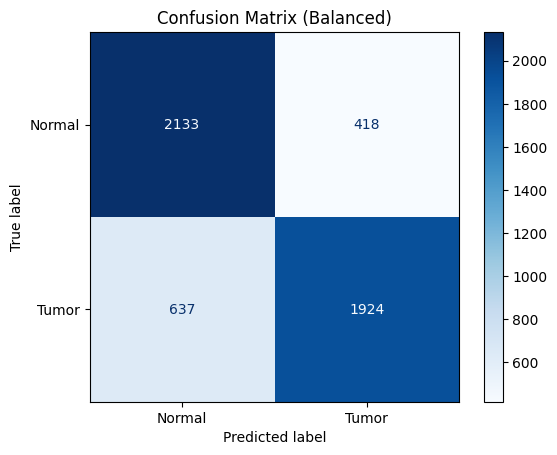

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# 7️⃣ Confusion Matrix 시각화
# =====================
cm = confusion_matrix(final_real, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Balanced)")
plt.show()


# transformer

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import time  # 추가

# Training loop
epoch_times = []  # 에포크별 시간 기록
epoch_losses = []  # 에포크별 평균 loss 기록
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# expr_balanced, labels_balanced 사용
expr_balanced = expr_balanced.astype(np.float32)
labels_balanced = labels_balanced.astype(np.int64)

# TensorDataset 생성
dataset = TensorDataset(torch.tensor(expr_balanced), torch.tensor(labels_balanced))

# Train/Test split (80/20)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer Encoder 기반 모델
class GeneTransformerWithAttn(nn.Module):
    def __init__(self, num_genes, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, num_classes=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation='relu'
            )
            for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, num_classes)
    
    def forward(self, x, return_attn=False):
        # x: [batch_size, num_genes]
        x = x.unsqueeze(-1)  # [batch_size, num_genes, 1]
        x = self.embedding(x)  # [batch_size, num_genes, d_model]
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, d_model]

        attn_matrices = []  # 저장할 attention
        for layer in self.layers:
            # forward에서 MultiheadAttention 객체 접근
            mha = layer.self_attn
            # mha.forward(q,k,v)에서 attn_weights 반환
            x2, attn = mha(x, x, x, need_weights=True)
            x = layer.norm1(x + layer.dropout1(x2))
            x2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
            x = layer.norm2(x + layer.dropout2(x2))
            attn_matrices.append(attn.detach())  # [batch_size, num_heads, seq_len, seq_len]

        x = x.mean(dim=0)  # global pooling over genes
        out = self.fc_out(x)

        if return_attn:
            return out, attn_matrices
        else:
            return out

num_genes = expr_balanced.shape[1]
model = GeneTransformerWithAttn(num_genes=num_genes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
start_time = time.time()  # 시작 시간 기록
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_losses.append(avg_loss)  # 기록
    end_time = time.time()  # 종료 시간 기록
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)  # 기록
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:03d}, Avg Train Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
preds = []
labels_true = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x)
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        labels_true.extend(batch_y.cpu().numpy())
        correct += (pred == batch_y).sum().item()
        total += batch_x.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# DataFrame 생성
df_epoch_log = pd.DataFrame({
    "Epoch": np.arange(1, len(epoch_losses)+1),
    "Avg_Train_Loss": epoch_losses,
    "Epoch_Time_sec": epoch_times
})

# CSV로 저장
df_epoch_log.to_csv("epoch_log_vanilTF.csv", index=False)

Using device: cuda
Epoch 001, Avg Train Loss: 0.5936
Epoch 002, Avg Train Loss: 0.5258
Epoch 003, Avg Train Loss: 0.5111
Epoch 004, Avg Train Loss: 0.4983
Epoch 005, Avg Train Loss: 0.4818
Epoch 006, Avg Train Loss: 0.4707
Epoch 007, Avg Train Loss: 0.4549
Epoch 008, Avg Train Loss: 0.4323
Epoch 009, Avg Train Loss: 0.4224
Epoch 010, Avg Train Loss: 0.4165
Epoch 011, Avg Train Loss: 0.4140
Epoch 012, Avg Train Loss: 0.3987
Epoch 013, Avg Train Loss: 0.3916
Epoch 014, Avg Train Loss: 0.3926
Epoch 015, Avg Train Loss: 0.3839
Epoch 016, Avg Train Loss: 0.3810
Epoch 017, Avg Train Loss: 0.3827
Epoch 018, Avg Train Loss: 0.3713
Epoch 019, Avg Train Loss: 0.3677
Epoch 020, Avg Train Loss: 0.3793
Epoch 021, Avg Train Loss: 0.3766
Epoch 022, Avg Train Loss: 0.3736
Epoch 023, Avg Train Loss: 0.3668
Epoch 024, Avg Train Loss: 0.3586
Epoch 025, Avg Train Loss: 0.3465
Epoch 026, Avg Train Loss: 0.3539
Epoch 027, Avg Train Loss: 0.3561
Epoch 028, Avg Train Loss: 0.3532
Epoch 029, Avg Train Loss: 0.

In [13]:
model.eval()
correct = 0
total = 0
preds = []
prediction=[]
real=[]
labels_true = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x,return_attn=True)[0]
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        prediction.append(pred.cpu().numpy())
        labels_true.extend(batch_y.cpu().numpy())
        real.append(batch_y.cpu().numpy())
        correct += (pred == batch_y).sum().item()
        total += batch_x.size(0)


final_pred=[]
for i in prediction:
    for j in i:
        final_pred.append(j)

final_real=[]
for i in real:
    for j in i:
        final_real.append(j)

attention_map=model(batch_x,return_attn=True)[1]

<Figure size 500x500 with 0 Axes>

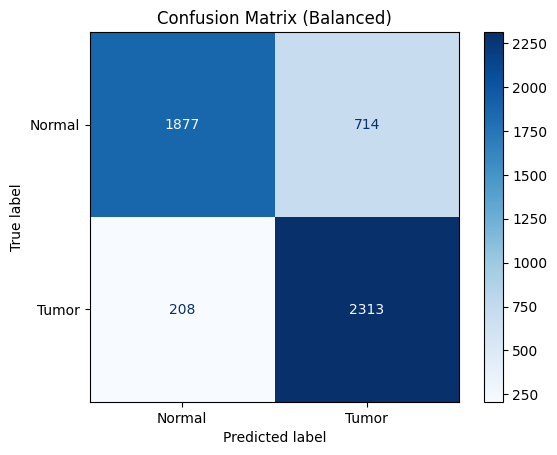

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# 7️⃣ Confusion Matrix 시각화
# =====================
cm = confusion_matrix(final_real, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Balanced)")
plt.show()


### attention map 분석

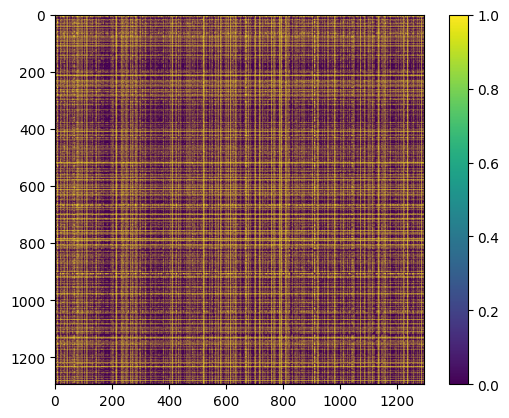

In [15]:
attmap=attention_map[0].detach().cpu().numpy()
att=attmap.mean(axis=0)
att_sym = (att > att.mean()).astype(int)
att_sym = np.logical_or(att_sym, att_sym.T).astype(int)
plt.imshow(att_sym, cmap='viridis')
plt.colorbar()
plt.show()

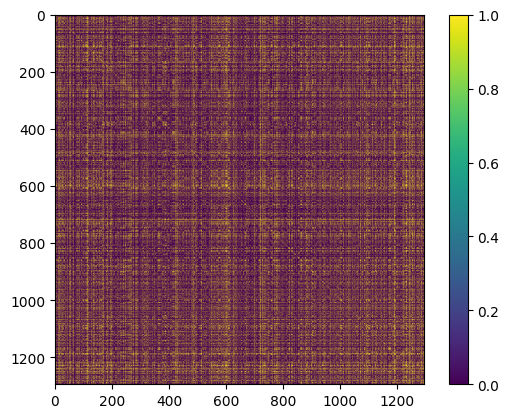

In [16]:
plt.imshow(adj.values, cmap='viridis')
plt.colorbar()
plt.show()

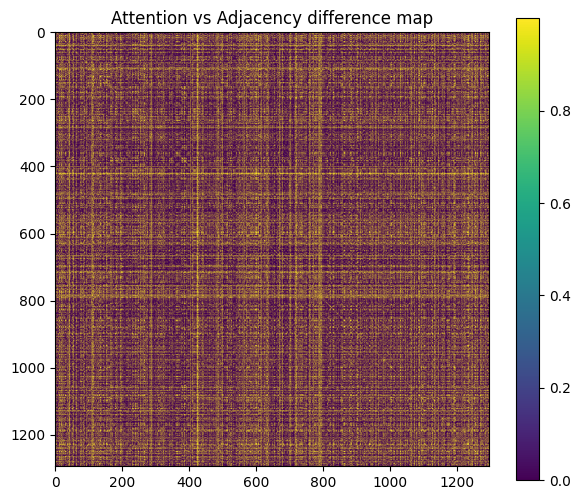

In [17]:
import matplotlib.pyplot as plt
import numpy as np

attmap=attention_map[0].detach().cpu().numpy()
att=attmap.mean(axis=0)
att_sym = (att + att.T) / 2
att_sym = (att_sym>att_sym.mean()).astype(int)
adj_np = adj

# adj를 0~1 사이로 맞추기 위해 조금 smoothing
adj_norm = (adj_np - adj_np.min()) / (adj_np.max() - adj_np.min() + 1e-9)

# attention도 정규화
att_norm = (att_sym - att_sym.min()) / (att_sym.max() - att_sym.min() + 1e-9)

# absolute difference map
diff = np.abs(att_norm - adj_norm)

plt.figure(figsize=(7, 6))
plt.imshow(diff, cmap='viridis')
plt.colorbar()
plt.title("Attention vs Adjacency difference map")
plt.show()

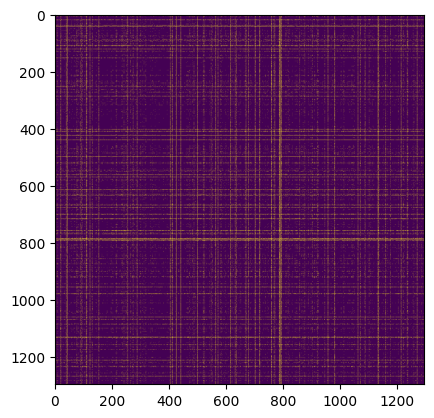

In [18]:
isOne=(att_norm - adj_norm)>0.5
plt.imshow(isOne, cmap='viridis')

In [19]:
from scipy.stats import pearsonr

corr, _ = pearsonr(att_sym.flatten(), adj_norm.values.flatten())
print("Correlation:", corr)

Correlation: 0.01637312866550228


### transformer이 집중한 gene 쌍

In [20]:
# True 값 위치 추출
edges = np.where(isOne)  # tuple of arrays (row_idx, col_idx)

# 행/열 이름으로 표현
edges_df = pd.DataFrame({
    'source': isOne.index[edges[0]],
    'target': isOne.columns[edges[1]]
})

print(edges_df.head())
print(f"총 연결 수: {len(edges_df)}")

   source target
0  RNASE7    CKM
1  RNASE7  WFDC2
2  RNASE7     MB
3  RNASE7  KRT17
4  RNASE7  KRT14
총 연결 수: 113304


In [21]:
corr_matrix = expr.corr()
corr_values = [corr_matrix.loc[src, tgt] for src, tgt in zip(edges_df['source'], edges_df['target'])]

In [22]:
import numpy as np

corr_values = np.array(corr_values)

n = 9  # 예: 5번째로 큰 값
# argsort는 오름차순 정렬 인덱스를 반환
sorted_idx = np.argsort(corr_values)  # 작은 값 → 큰 값 순
nth_largest_idx = sorted_idx[-n]      # 뒤에서 n번째

print(f"{n}번째로 큰 값의 index:", nth_largest_idx)
print(f"값:", corr_values[nth_largest_idx])

9번째로 큰 값의 index: 22986
값: 0.7707160200562246


In [23]:
edges_df.iloc[nth_largest_idx]

source    FXYD3
target     PKP3
Name: 22986, dtype: object

# graph injected transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
import time  # 추가

# Training loop
epoch_times = []  # 에포크별 시간 기록
epoch_losses = []  # 에포크별 평균 loss 기록
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# expression 데이터와 labels 준비
expr = expr_withlabel.drop(columns=['label'])
labels = expr_withlabel['label'].values

# 클래스별 인덱스 추출
tumor_idx = np.where(labels == 1)[0]
normal_idx = np.where(labels == 0)[0]

# Normal 클래스 크기에 맞춰 Tumor downsampling
n_samples = len(normal_idx)
down_tumor_idx = resample(tumor_idx, replace=False, n_samples=n_samples, random_state=42)

# Balanced dataset
balanced_idx = np.concatenate([normal_idx, down_tumor_idx])
np.random.shuffle(balanced_idx)

expr_balanced = expr.iloc[balanced_idx].values
labels_balanced = labels[balanced_idx]

print(f"Balanced dataset: Normal={len(normal_idx)}, Tumor={len(down_tumor_idx)}")
expr_balanced = expr_balanced.astype(np.float32)
labels_balanced = labels_balanced.astype(np.int64)
dataset = TensorDataset(torch.tensor(expr_balanced), torch.tensor(labels_balanced))

# Train/Test split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Multi-head Attention Transformer 모델
class GeneTransformerMasked(nn.Module):
    def __init__(self, num_genes, d_model=64, nhead=8, num_layers=2, dim_feedforward=128, num_classes=2, dropout=0.1):
        super().__init__()
        self.num_heads = nhead

        self.embedding = nn.Linear(1, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation='relu',
                batch_first=False
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x, adj, return_attn=False):
        # x: [batch_size, num_genes]
        x = x.unsqueeze(-1)  # [batch, genes, 1]
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # [seq_len, batch, d_model]

        seq_len = x.size(0)

        # adjacency → mask 생성 (True=block)
        attn_mask = torch.tensor(adj == 0, dtype=torch.bool, device=x.device)  # [seq, seq]

        attn_matrices = []

        for layer in self.layers:
            # MHA 내부 객체 꺼내기
            mha = layer.self_attn

            # MultiheadAttention forward 직접 호출하여 attn 얻기
            x2, attn = mha(
                x, x, x,
                attn_mask=attn_mask,         # (L, L)
                need_weights=True,
                average_attn_weights=False   # head별로 반환
            )

            # TransformerEncoderLayer 후처리 직접 수행
            x = layer.norm1(x + layer.dropout1(x2))
            x2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
            x = layer.norm2(x + layer.dropout2(x2))

            attn_matrices.append(attn.detach())

        x = x.mean(dim=0)
        out = self.fc_out(x)

        if return_attn:
            return out, attn_matrices
        else:
            return out


num_genes = expr_balanced.shape[1]
model = GeneTransformerMasked(num_genes=num_genes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 50
start_time = time.time()  # 시작 시간 기록
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        out = model(batch_x, adj.values)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_losses.append(avg_loss)  # 기록
    end_time = time.time()  # 종료 시간 기록
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)  # 기록
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1:03d}, Avg Train Loss: {avg_loss:.4f}")

# DataFrame 생성
df_epoch_log = pd.DataFrame({
    "Epoch": np.arange(1, len(epoch_losses)+1),
    "Avg_Train_Loss": epoch_losses,
    "Epoch_Time_sec": epoch_times
})

# CSV로 저장
df_epoch_log.to_csv("epoch_log_GITF.csv", index=False)

Using device: cuda
Balanced dataset: Normal=8519, Tumor=8519
Epoch 001, Avg Train Loss: 0.5858
Epoch 002, Avg Train Loss: 0.5035
Epoch 003, Avg Train Loss: 0.4710
Epoch 004, Avg Train Loss: 0.4498
Epoch 005, Avg Train Loss: 0.4291
Epoch 006, Avg Train Loss: 0.4060
Epoch 007, Avg Train Loss: 0.4017
Epoch 008, Avg Train Loss: 0.3866
Epoch 009, Avg Train Loss: 0.3740
Epoch 010, Avg Train Loss: 0.3739
Epoch 011, Avg Train Loss: 0.3583
Epoch 012, Avg Train Loss: 0.3526
Epoch 013, Avg Train Loss: 0.3700
Epoch 014, Avg Train Loss: 0.3527
Epoch 015, Avg Train Loss: 0.3329
Epoch 016, Avg Train Loss: 0.3485
Epoch 017, Avg Train Loss: 0.3278
Epoch 018, Avg Train Loss: 0.3323
Epoch 019, Avg Train Loss: 0.3233
Epoch 020, Avg Train Loss: 0.3126
Epoch 021, Avg Train Loss: 0.3243
Epoch 022, Avg Train Loss: 0.3021
Epoch 023, Avg Train Loss: 0.3048
Epoch 024, Avg Train Loss: 0.2953
Epoch 025, Avg Train Loss: 0.2977
Epoch 026, Avg Train Loss: 0.2967
Epoch 027, Avg Train Loss: 0.2873
Epoch 028, Avg Train 

In [25]:
model.eval()
correct = 0
total = 0
preds = []
prediction=[]
real=[]
labels_true = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x,adj.values,return_attn=True)[0]
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        prediction.append(pred.cpu().numpy())
        labels_true.extend(batch_y.cpu().numpy())
        real.append(batch_y.cpu().numpy())
        correct += (pred == batch_y).sum().item()
        total += batch_x.size(0)


final_pred=[]
for i in prediction:
    for j in i:
        final_pred.append(j)

final_real=[]
for i in real:
    for j in i:
        final_real.append(j)

attn_weights=model(batch_x,adj.values,return_attn=True)[1]

<Figure size 500x500 with 0 Axes>

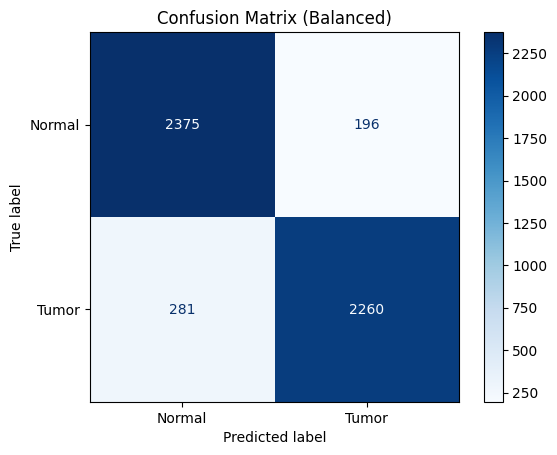

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# 7️⃣ Confusion Matrix 시각화
# =====================
cm = confusion_matrix(final_real, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Balanced)")
plt.show()


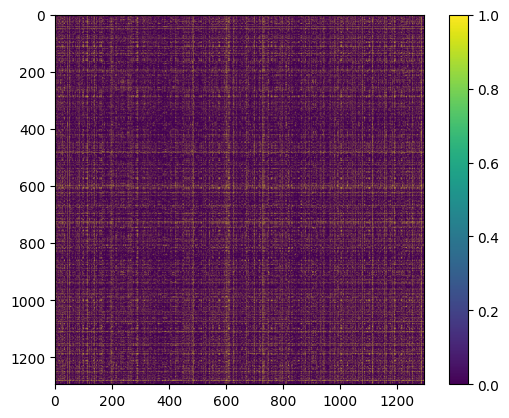

In [27]:
attmap=attn_weights[0].detach().cpu().numpy()
att=attmap[0].mean(axis=0)
att_sym = (att > att.mean()).astype(int)
att_sym = np.logical_or(att_sym, att_sym.T).astype(int)
plt.imshow(att_sym, cmap='viridis')
plt.colorbar()
plt.show()

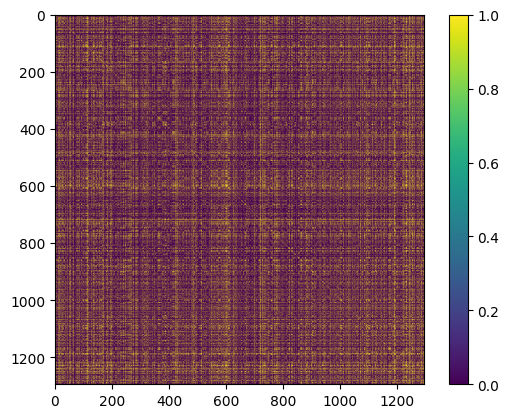

In [28]:
plt.imshow(adj.values, cmap='viridis')
plt.colorbar()
plt.show()

In [29]:
from scipy.stats import pearsonr

corr, _ = pearsonr(att_sym.flatten(), adj.values.flatten())
print("Correlation:", corr)

Correlation: 0.6549126679730711


# graph injected transformer(local)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np
import time  # 추가

# Training loop
epoch_times = []  # 에포크별 시간 기록
epoch_losses = []  # 에포크별 평균 loss 기록
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# -----------------------------
# 1) Masked Transformer 정의
# -----------------------------
class GeneTransformerHeadMasked(nn.Module):
    def __init__(self, num_genes, d_model=64, nhead=8, num_layers=2,
                 dim_feedforward=128, num_classes=2, dropout=0.1):
        super().__init__()
        self.num_heads = nhead
        self.num_layers = num_layers

        self.embedding = nn.Linear(1, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=False,
                activation='relu'
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x, head_masks=None, return_atts=False):
        x = x.unsqueeze(-1)        # [batch, genes, 1]
        x = self.embedding(x)
        x = x.permute(1, 0, 2)     # [genes, batch, d_model]

        attn_outputs = []

        for layer_idx, layer in enumerate(self.layers):
            mha = layer.self_attn

            x2, attn = mha(
                x, x, x,
                need_weights=True,
                average_attn_weights=False,
                attn_mask=None
            )

            x = layer.norm1(x + layer.dropout1(x2))
            x2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))
            x = layer.norm2(x + layer.dropout2(x2))

            attn_outputs.append(attn)

        x = x.mean(dim=0)
        out = self.fc_out(x)

        if return_atts:
            return out, attn_outputs
        else:
            return out


# -----------------------------
# GPU 적용된 head mask 생성
# -----------------------------
def generate_block_head_masks(adj,
                              nhead=8,
                              flip_prob=0.0,
                              device="cuda"):
    """
    adj: torch.BoolTensor [L, L]  (True = edge exists)
    block_size: 블록 크기
    flip_prob: 블록 내부에서 True/False 랜덤 뒤집기 확률

    반환:
        [nhead, L, L]  mask
        True = block (attn 제외), False = allow
    """

    L = adj.shape[0]
    
    # adj 존재하는 부분은 allow (=False), 없는 부분은 block (=True)
    base_block = (adj).clone().to(device)

    # -------------------------------------
    # 1) 블록 외부는 항상 False (allow)
    # -------------------------------------

    # 전체 영역을 block_size × block_size로 쪼개기


    # -------------------------------------
    # 2) head별 mask 생성
    #    블록 내부만 랜덤 flip, 블록 외부는 0
    # -------------------------------------
    head_masks = []

    for h in range(nhead):
        # head별 block 크기를 랜덤하게 선택
        block_size = np.random.randint(50, 200)
        block_mask = torch.zeros_like(base_block, dtype=torch.bool, device=device)

        # head별로 "격자의 block on/off" 패턴을 무작위로 만듦
        # 예: block_on = True → 이 block을 active로 사용
        #     block_on = False → 해당 block은 비활성화 (모두 False)
        block_on_prob = 0.5  # 조절 가능
        block_on = torch.rand((L // block_size + 1, L // block_size + 1), device=device) < block_on_prob

        for bi, i in enumerate(range(0, L, block_size)):
            for bj, j in enumerate(range(0, L, block_size)):
                i2 = min(i + block_size, L)
                j2 = min(j + block_size, L)

                if block_on[bi, bj]:
                    # active block → adj 기반 block 정보 사용
                    block_mask[i:i2, j:j2] = (base_block[i:i2, j:j2]==0)
                else:
                    # inactive block → 완전 False (mask 없음)
                    block_mask[i:i2, j:j2] = False

        head_masks.append(block_mask)

    return torch.stack(head_masks, dim=0)  # [nhead, L, L]

# -----------------------------
# 데이터 준비 (CPU → GPU는 batch에서)
# -----------------------------
expr = expr_withlabel.drop(columns=['label'])
labels = expr_withlabel['label'].values

tumor_idx  = np.where(labels == 1)[0]
normal_idx = np.where(labels == 0)[0]

n_samples = len(normal_idx)
down_tumor_idx = resample(tumor_idx, replace=False, n_samples=n_samples, random_state=42)

balanced_idx = np.concatenate([normal_idx, down_tumor_idx])
np.random.shuffle(balanced_idx)

expr_balanced = expr.iloc[balanced_idx].values.astype(np.float32)
labels_balanced = labels[balanced_idx].astype(np.int64)

dataset = TensorDataset(torch.tensor(expr_balanced), torch.tensor(labels_balanced))

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_genes = expr_balanced.shape[1]


# -----------------------------
# 4) 모델 GPU로 이동
# -----------------------------
model = GeneTransformerHeadMasked(
    num_genes=num_genes, nhead=8, num_layers=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


# -----------------------------
# 5) Training
# -----------------------------
start_time = time.time()  # 시작 시간 기록
for epoch in range(50):
    model.train()
    epoch_loss = 0

    # epoch마다 mask 생성 + GPU
    masks = [generate_block_head_masks(adj=torch.tensor(adj.values))
             for _ in range(2)]

    for bx, by in train_loader:
        bx = bx.to(device)
        by = by.to(device)

        out = model(bx, head_masks=masks)
        loss = criterion(out, by)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * bx.size(0)
    epoch_losses.append(avg_loss)  # 기록
    end_time = time.time()  # 종료 시간 기록
    epoch_duration = end_time - start_time
    epoch_times.append(epoch_duration)  # 기록
    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"[Epoch {epoch+1}] Loss = {epoch_loss / len(train_loader.dataset):.4f}")

# DataFrame 생성
df_epoch_log = pd.DataFrame({
    "Epoch": np.arange(1, len(epoch_losses)+1),
    "Avg_Train_Loss": epoch_losses,
    "Epoch_Time_sec": epoch_times
})

# CSV로 저장
df_epoch_log.to_csv("epoch_log_GITF_blocked.csv", index=False)

Using device: cuda
[Epoch 1] Loss = 0.6050
[Epoch 2] Loss = 0.5411
[Epoch 3] Loss = 0.5196
[Epoch 4] Loss = 0.5060
[Epoch 5] Loss = 0.4781
[Epoch 6] Loss = 0.4600
[Epoch 7] Loss = 0.4507
[Epoch 8] Loss = 0.4332
[Epoch 9] Loss = 0.4201
[Epoch 10] Loss = 0.4215
[Epoch 11] Loss = 0.4015
[Epoch 12] Loss = 0.3947
[Epoch 13] Loss = 0.3862
[Epoch 14] Loss = 0.3820
[Epoch 15] Loss = 0.3781
[Epoch 16] Loss = 0.3702
[Epoch 17] Loss = 0.3731
[Epoch 18] Loss = 0.3620
[Epoch 19] Loss = 0.3638
[Epoch 20] Loss = 0.3593
[Epoch 21] Loss = 0.3519
[Epoch 22] Loss = 0.3530
[Epoch 23] Loss = 0.3483
[Epoch 24] Loss = 0.3444
[Epoch 25] Loss = 0.3524
[Epoch 26] Loss = 0.3489
[Epoch 27] Loss = 0.3403
[Epoch 28] Loss = 0.3411
[Epoch 29] Loss = 0.3439
[Epoch 30] Loss = 0.3361
[Epoch 31] Loss = 0.3367
[Epoch 32] Loss = 0.3297
[Epoch 33] Loss = 0.3290
[Epoch 34] Loss = 0.3329
[Epoch 35] Loss = 0.3330
[Epoch 36] Loss = 0.3381
[Epoch 37] Loss = 0.3170
[Epoch 38] Loss = 0.3263
[Epoch 39] Loss = 0.3153
[Epoch 40] Loss

In [16]:
model.eval()
correct = 0
total = 0
preds = []
prediction=[]
real=[]
labels_true = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        out = model(batch_x,return_atts=True)[0]
        pred = torch.argmax(out, dim=1)
        preds.extend(pred.cpu().numpy())
        prediction.append(pred.cpu().numpy())
        labels_true.extend(batch_y.cpu().numpy())
        real.append(batch_y.cpu().numpy())
        correct += (pred == batch_y).sum().item()
        total += batch_x.size(0)


final_pred=[]
for i in prediction:
    for j in i:
        final_pred.append(j)

final_real=[]
for i in real:
    for j in i:
        final_real.append(j)

attention_map=model(batch_x,return_atts=True)[1]

<Figure size 500x500 with 0 Axes>

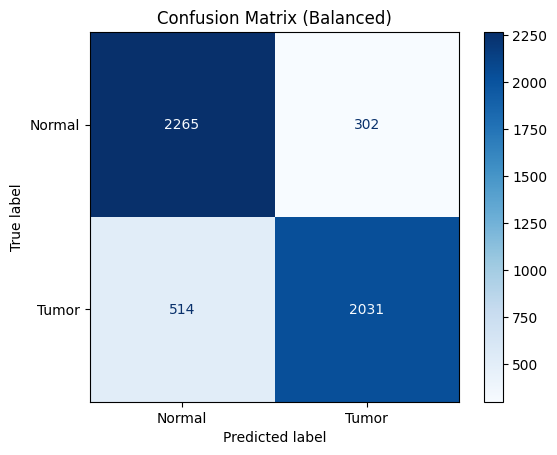

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# =====================
# 7️⃣ Confusion Matrix 시각화
# =====================
cm = confusion_matrix(final_real, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Tumor"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Balanced)")
plt.show()


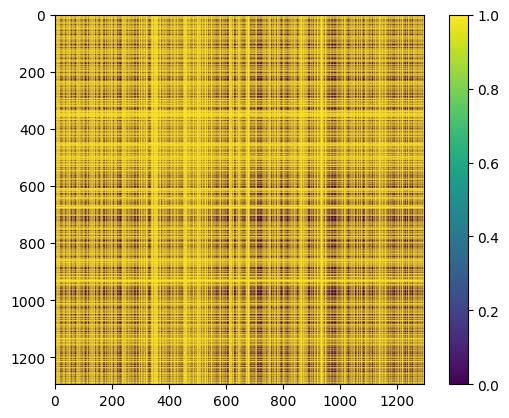

In [18]:
attmap=attention_map[0].detach().cpu().numpy()
att=attmap[0].mean(axis=0)
att_sym = (att > att.mean()).astype(int)
att_sym = np.logical_or(att_sym, att_sym.T).astype(int)
plt.imshow(att_sym, cmap='viridis')
plt.colorbar()
plt.show()

In [19]:
from scipy.stats import pearsonr

corr, _ = pearsonr(att_sym.flatten(), adj.values.flatten())
print("Correlation:", corr)

Correlation: -0.015160815303962925


### attention mask 비교

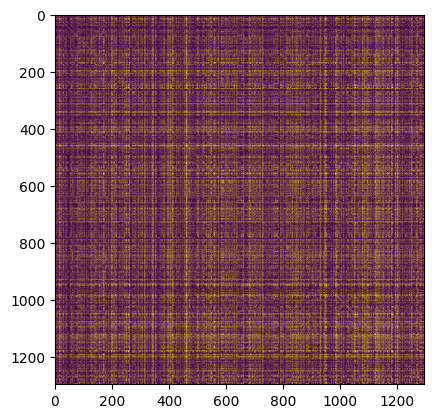

In [20]:
plt.imshow(torch.tensor(adj.values))

In [36]:
def generate_block_head_masks(adj,
                              nhead=8,
                              flip_prob=0.0,
                              device="cuda"):
    """
    adj: torch.BoolTensor [L, L]  (True = edge exists)
    block_size: 블록 크기
    flip_prob: 블록 내부에서 True/False 랜덤 뒤집기 확률

    반환:
        [nhead, L, L]  mask
        True = block (attn 제외), False = allow
    """

    L = adj.shape[0]
    
    # adj 존재하는 부분은 allow (=False), 없는 부분은 block (=True)
    base_block = (adj).clone().to(device)

    # -------------------------------------
    # 1) 블록 외부는 항상 False (allow)
    # -------------------------------------

    # 전체 영역을 block_size × block_size로 쪼개기


    # -------------------------------------
    # 2) head별 mask 생성
    #    블록 내부만 랜덤 flip, 블록 외부는 0
    # -------------------------------------
    head_masks = []

    for h in range(nhead):
        # head별 block 크기를 랜덤하게 선택
        block_size = np.random.randint(50, 200)
        block_mask = torch.zeros_like(base_block, dtype=torch.bool, device=device)

        # head별로 "격자의 block on/off" 패턴을 무작위로 만듦
        # 예: block_on = True → 이 block을 active로 사용
        #     block_on = False → 해당 block은 비활성화 (모두 False)
        block_on_prob = 0.5  # 조절 가능
        block_on = torch.rand((L // block_size + 1, L // block_size + 1), device=device) < block_on_prob

        for bi, i in enumerate(range(0, L, block_size)):
            for bj, j in enumerate(range(0, L, block_size)):
                i2 = min(i + block_size, L)
                j2 = min(j + block_size, L)

                if block_on[bi, bj]:
                    # active block → adj 기반 block 정보 사용
                    block_mask[i:i2, j:j2] = (base_block[i:i2, j:j2]==0)
                else:
                    # inactive block → 완전 False (mask 없음)
                    block_mask[i:i2, j:j2] = False

        head_masks.append(block_mask)

    return torch.stack(head_masks, dim=0)  # [nhead, L, L]

In [37]:
a=generate_block_head_masks(adj=torch.tensor(adj.values))

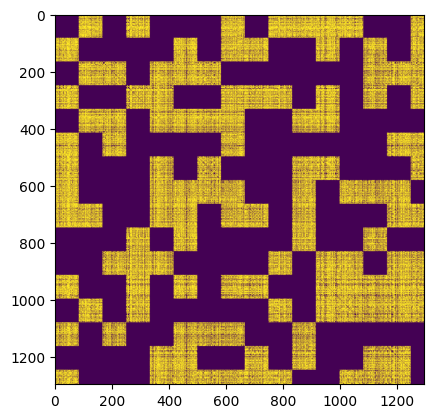

In [62]:
import matplotlib.pyplot as plt
plt.imshow(a[7].detach().cpu().numpy())